Requirements:

creditcard.csv: original credit card dataset

synthetic_data.csv: synthetic data made without clustering

synthetic_data_cluster_1, synthetic_data_cluster_2, synthetic_data_cluster_3: synthetic data made from three clusters

In [1]:
%%capture
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [21]:
import os
import datetime
import torch
from sklearn import metrics
import pandas as pd
import umap
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

In [23]:
str_time = datetime.datetime.now().replace(microsecond=0).isoformat(sep='_').replace(':', 'h', 1).replace(':', 'm', 1)
folder_result = 'results_ML/' + 'UMAP_and_Classification' + '/Report_' + str_time
os.makedirs(folder_result)

In [10]:
df_original = pd.read_csv('datasets/creditcard.csv').drop('Time', axis=1)

In [12]:
X_train, X_test = train_test_split(df_original, test_size=0.2, random_state=42, stratify=df_original['Class'])

In [13]:
# check prevalence of fraud data in train and test sets (stratify does its job!)
X_train['Class'].value_counts()[1] / len(X_train)

np.float64(0.001729245759178389)

In [14]:
X_test['Class'].value_counts()[1] / len(X_test)

np.float64(0.0017204452090867595)

In [15]:
sc = StandardScaler()
X_train['Amount'] = sc.fit_transform(X_train['Amount'].values.reshape(-1, 1))
X_test['Amount'] = sc.transform(X_test['Amount'].values.reshape(-1, 1))

In [16]:
fraud_train = X_train[X_train['Class'] == 1].drop('Class', axis=1)
fraud_test = X_test[X_test['Class'] == 1].drop('Class', axis=1)
legit_train = X_train[X_train['Class'] == 0].drop('Class', axis=1)

In [17]:
reducer = umap.UMAP(n_neighbors=25, random_state=42)

In [18]:
fraud_train_reduced = reducer.fit_transform(fraud_train.values)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [19]:
legit_train_reduced = reducer.transform(legit_train.values)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
np.random.seed(42)
legit_train_reduced_sample = legit_train_reduced[np.random.choice(legit_train_reduced.shape[0], 20000, replace=False)]

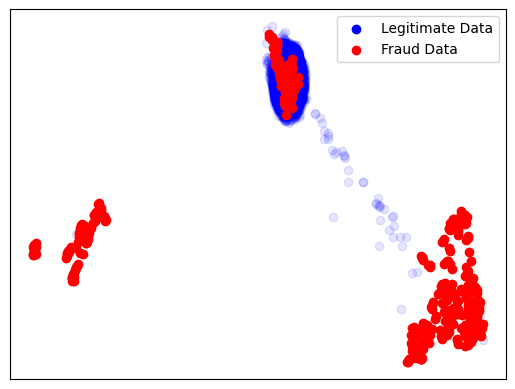

In [44]:
plt.scatter(legit_train_reduced_sample[:, 0], legit_train_reduced_sample[:, 1], label='Legitimate Data', alpha=0.1, color='b')
plt.scatter(fraud_train_reduced[:, 0], fraud_train_reduced[:, 1], label='Fraud Data', color='r')
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.savefig(folder_result + '/umap.pdf')

In [26]:
clustering = KMeans(n_clusters=3, random_state=42)
fraud_train_clustered = clustering.fit_predict(fraud_train_reduced)

In [27]:
cluster1 = fraud_train_reduced[fraud_train_clustered == 0]
cluster2 = fraud_train_reduced[fraud_train_clustered == 1]
cluster3 = fraud_train_reduced[fraud_train_clustered == 2]

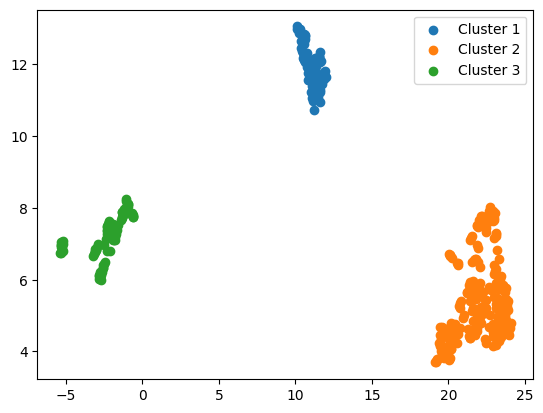

In [28]:
plt.scatter(cluster1[:, 0], cluster1[:, 1], label='Cluster 1')
plt.scatter(cluster2[:, 0], cluster2[:, 1], label='Cluster 2')
plt.scatter(cluster3[:, 0], cluster3[:, 1], label='Cluster 3')
plt.legend()

In [29]:
cluster_1 = fraud_train.iloc[fraud_train_clustered == 0]
cluster_2 = fraud_train.iloc[fraud_train_clustered == 1]
cluster_3 = fraud_train.iloc[fraud_train_clustered == 2]

In [30]:
# Notice: approximately 20% in cluster 1, 60% in cluster 2, 20% in cluster 3
cluster_1_prop = len(cluster_1) / (len(cluster_1) + len(cluster_2) + len(cluster_3))
cluster_2_prop = len(cluster_2) / (len(cluster_1) + len(cluster_2) + len(cluster_3))
cluster_3_prop = len(cluster_3) / (len(cluster_1) + len(cluster_2) + len(cluster_3))
cluster_1_prop, cluster_2_prop, cluster_3_prop

(0.20304568527918782, 0.5812182741116751, 0.21573604060913706)

Saving the data in these three clusters will give you the csv files found in the datasets folder. They are already available in this repository, so there is no need to save them again here.

In [72]:
# first idea: train on all three clusters together, then generate
synthetic_data_whole = pd.read_csv('synthetic_creditcard_data/synthetic_data_whole.csv')
synthetic_data_reduced_whole = reducer.transform(synthetic_data_whole.sample(3000, random_state=42))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


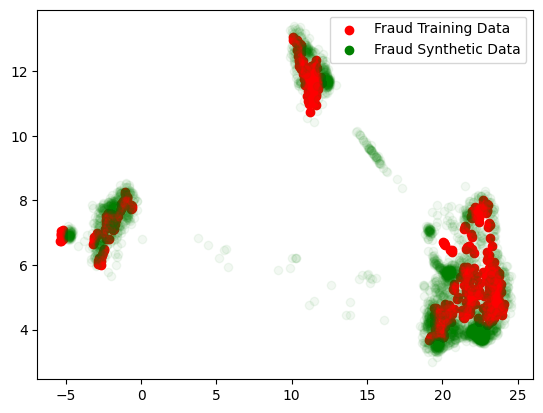

In [73]:
plt.scatter(fraud_train_reduced[:, 0], fraud_train_reduced[:, 1], label='Fraud Training Data', color='r')
plt.scatter(synthetic_data_reduced_whole[:, 0], synthetic_data_reduced_whole[:, 1], label='Fraud Synthetic Data', alpha=.05, color='g')
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.savefig(folder_result + '/umap_with_whole_synthetic_data.pdf')

In [74]:
# alternate idea: train on each cluster separately, then generate from each cluster
synthetic_cluster_1 = pd.read_csv('synthetic_creditcard_data/synthetic_data_cluster_1.csv').sample(600, random_state=42)
synthetic_cluster_2 = pd.read_csv('synthetic_creditcard_data/synthetic_data_cluster_2.csv').sample(1800, random_state=42)
synthetic_cluster_3 = pd.read_csv('synthetic_creditcard_data/synthetic_data_cluster_3.csv').sample(600, random_state=42)
synthetic_data = pd.concat([synthetic_cluster_1, synthetic_cluster_2, synthetic_cluster_3])

In [75]:
synthetic_data_reduced = reducer.transform(synthetic_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


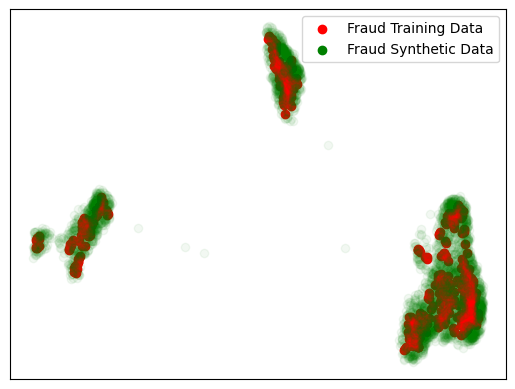

In [76]:
plt.scatter(fraud_train_reduced[:, 0], fraud_train_reduced[:, 1], label='Fraud Training Data', color='r')
plt.scatter(synthetic_data_reduced[:, 0], synthetic_data_reduced[:, 1], label='Fraud Synthetic Data', alpha=.05, color='g')
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.savefig(folder_result + '/umap_with_clustered_synthetic_data.pdf')

Visually, the "train on each cluster" approach gives us a much better coverage of the data when reduced to 2D!

We can compare the performance of augmentation with diffusion versus Synthetic Minority Over-sampling Technique (SMOTE), which is explained in:
\
Nitesh V. Chawla et al. "SMOTE: Synthetic Minority Over-sampling Technique". In: Journal of Artificial Intelligence Research (2002).
\
url: https://www.jair.org/index.php/jair/article/view/10302/24590

In [77]:
sm = SMOTE(random_state=42)  # uses 5 neighbors by default
X_train_smote, y_train_smote = sm.fit_resample(X_train.drop('Class', axis=1), X_train['Class'])
X_train_smote['Class'] = y_train_smote
new_smote_data = pd.concat([X_train, X_train_smote]).drop_duplicates(keep=False)
smote_data_reduced = reducer.transform(new_smote_data.sample(3000, random_state=42))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


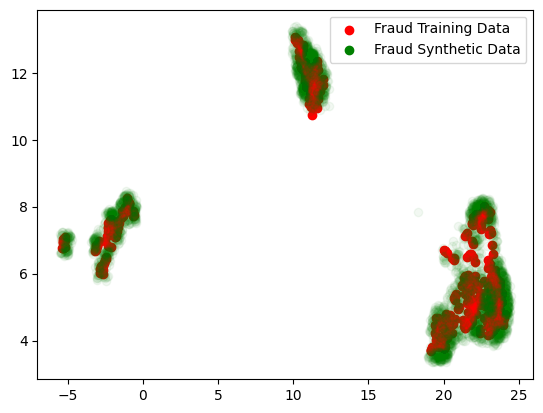

In [78]:
plt.scatter(fraud_train_reduced[:, 0], fraud_train_reduced[:, 1], label='Fraud Training Data', color='r')
plt.scatter(smote_data_reduced[:, 0], smote_data_reduced[:, 1], label='Fraud Synthetic Data', alpha=.05, color='g')
leg = plt.legend()
for lh in leg.legend_handles:
    lh.set_alpha(1)
plt.savefig(folder_result + '/umap_with_smote_synthetic_data.pdf')

In [79]:
# now classification
class_names = ['Legit', 'Fraud']
def classify(classifier, X_train, y_train, X_test, y_test, title='Confusion Matrix', filename='cm.pdf'):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, colorbar=False)
    plt.xticks(ticks=[0, 1], labels=class_names)
    plt.yticks(ticks=[0, 1], labels=class_names)
    plt.title(title)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(f'F1 Score: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    plt.savefig(folder_result + "/" + filename)
    plt.show()

In [80]:
xgb_classifier = xgb.XGBClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=50)

F1 Score: 0.8571428571428571
Precision: 0.8901098901098901
Recall: 0.826530612244898


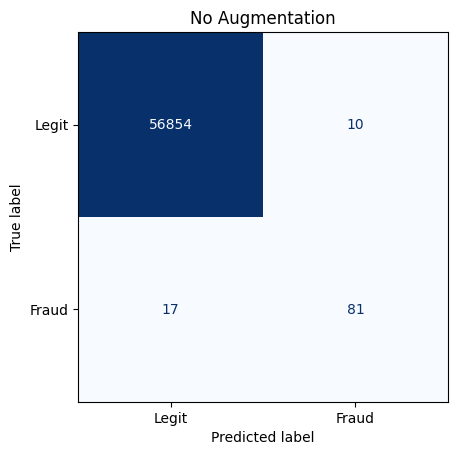

F1 Score: 0.8791208791208791
Precision: 0.9523809523809523
Recall: 0.8163265306122449


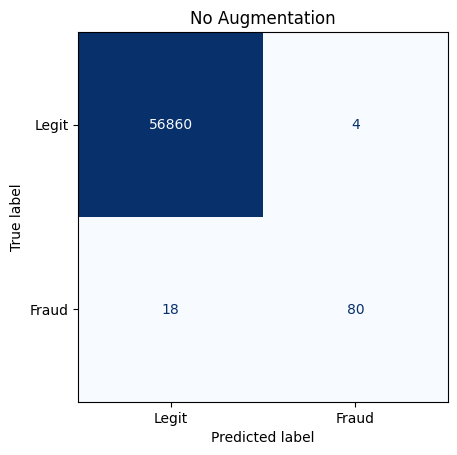

In [58]:
# without augmenting the data
classify(xgb_classifier, X_train.drop('Class', axis=1), X_train['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'No Augmentation', 'unaugmented_xgb.png')
classify(rf_classifier, X_train.drop('Class', axis=1), X_train['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'No Augmentation', 'unaugmented_rf.png')

In [81]:
# add synthetic data without clusters
synthetic_data_whole['Class'] = np.repeat(1, len(synthetic_data_whole))
X_train_augmented = pd.concat([X_train, synthetic_data_whole.sample(3000, random_state=42)])

F1 Score: 0.8663101604278075
Precision: 0.9101123595505618
Recall: 0.826530612244898


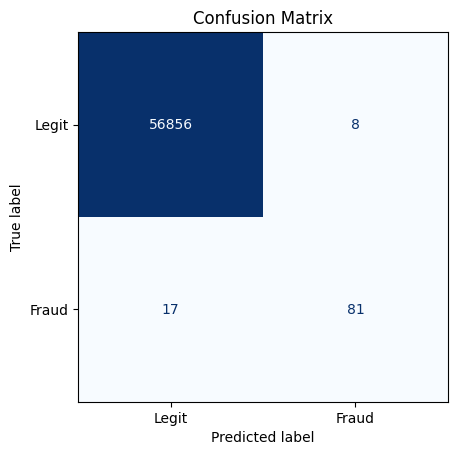

F1 Score: 0.8865979381443299
Precision: 0.8958333333333334
Recall: 0.8775510204081632


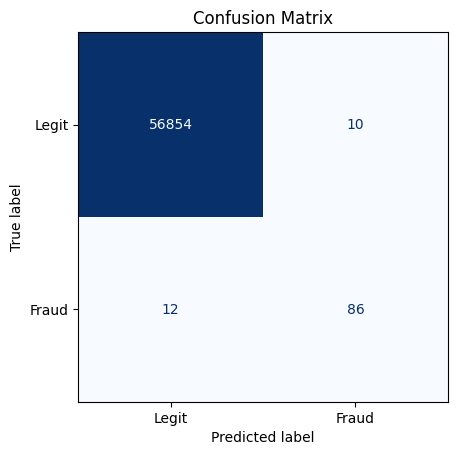

In [82]:
classify(xgb_classifier, X_train_augmented.drop('Class', axis=1), X_train_augmented['Class'], X_test.drop('Class', axis=1), X_test['Class'], filename='no_clusters_xgb.png')
classify(rf_classifier, X_train_augmented.drop('Class', axis=1), X_train_augmented['Class'], X_test.drop('Class', axis=1), X_test['Class'], filename='no_clusters_rf.png')

In [83]:
# add synthetic fraud data from "three clusters" approach
synthetic_data['Class'] = np.repeat(1, len(synthetic_data))
X_train_augmented_clusters = pd.concat([X_train, synthetic_data])

F1 Score: 0.8601036269430051
Precision: 0.8736842105263158
Recall: 0.8469387755102041


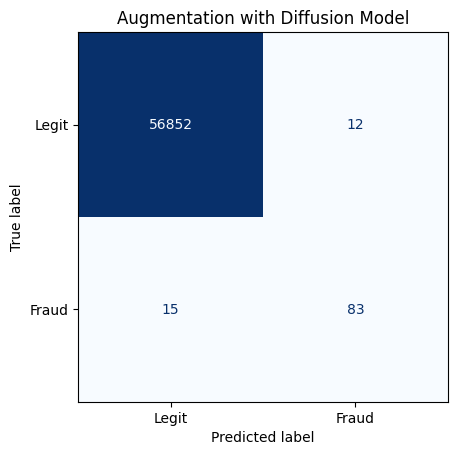

F1 Score: 0.8911917098445595
Precision: 0.9052631578947369
Recall: 0.8775510204081632


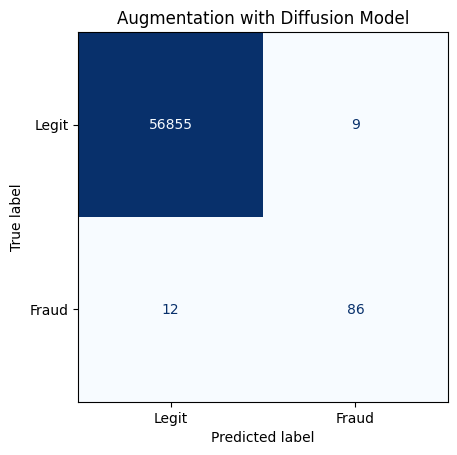

In [84]:
classify(xgb_classifier, X_train_augmented_clusters.drop('Class', axis=1), X_train_augmented_clusters['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'Augmentation with Diffusion Model', 'clusters_xgb.png')
classify(rf_classifier, X_train_augmented_clusters.drop('Class', axis=1), X_train_augmented_clusters['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'Augmentation with Diffusion Model', 'clusters_rf.png')

In [87]:
# try out smote:
synthetic_data_smote = new_smote_data.sample(3000, random_state=42)
X_train_augmented_smote = pd.concat([X_train, synthetic_data_smote])

F1 Score: 0.8691099476439791
Precision: 0.8924731182795699
Recall: 0.8469387755102041


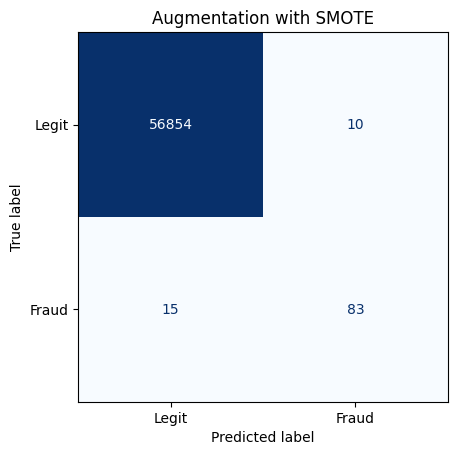

F1 Score: 0.8736842105263158
Precision: 0.9021739130434783
Recall: 0.8469387755102041


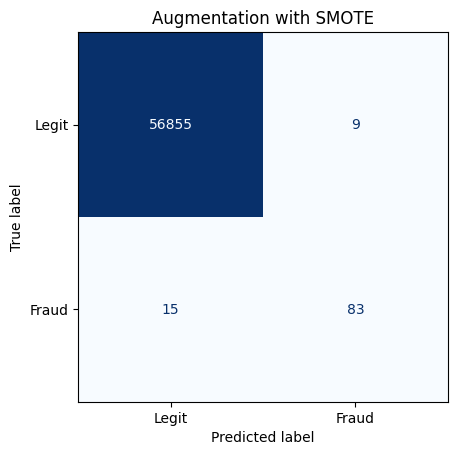

In [88]:
classify(xgb_classifier, X_train_augmented_smote.drop('Class', axis=1), X_train_augmented_smote['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'Augmentation with SMOTE', 'smote_xgb.png')
classify(rf_classifier, X_train_augmented_smote.drop('Class', axis=1), X_train_augmented_smote['Class'], X_test.drop('Class', axis=1), X_test['Class'], 'Augmentation with SMOTE', 'smote_rf.png')

In [89]:
# Summary of results:
xgb_results = pd.DataFrame(columns=['Method', 'F1 Score', 'Precision', 'Recall'])
xgb_results.loc[0] = ['No Changes', 0.8571, 0.8901, 0.8265]
xgb_results.loc[1] = ['Synthetic Data (No Clusters)', 0.8663, 0.9101, 0.8265]
xgb_results.loc[2] = ['Synthetic Data (Clusters)', 0.8601, 0.8737, 0.8469]
xgb_results.loc[3] = ['Synthetic Data (SMOTE)', 0.8691 , 0.8925, 0.8469]
xgb_results.head()

,Method,F1 Score,Precision,Recall
0,No Changes,0.8571,0.8901,0.8265
1,Synthetic Data (No Clusters),0.8663,0.9101,0.8265
2,Synthetic Data (Clusters),0.8601,0.8737,0.8469
3,Synthetic Data (SMOTE),0.8691,0.8925,0.8469


In [90]:
rf_results = pd.DataFrame(columns=['Method', 'F1 Score', 'Precision', 'Recall'])
rf_results.loc[0] = ['No Changes', 0.8791, 0.9524, 0.8163]
rf_results.loc[1] = ['Synthetic Data (No Clusters)', 0.8866, 0.8958, 0.8776]
rf_results.loc[2] = ['Synthetic Data (Clusters)', 0.8912, 0.9053, 0.8776]
rf_results.loc[3] = ['Synthetic Data (SMOTE)', 0.8737, 0.9022, 0.8469]
rf_results.head()

,Method,F1 Score,Precision,Recall
0,No Changes,0.8791,0.9524,0.8163
1,Synthetic Data (No Clusters),0.8866,0.8958,0.8776
2,Synthetic Data (Clusters),0.8912,0.9053,0.8776
3,Synthetic Data (SMOTE),0.8737,0.9022,0.8469
